In [155]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage
from sklearn.cluster import KMeans
from modules.cv_helpers import find_bounding_boxes, find_cluster_centers, plot_boxes, plot_centers

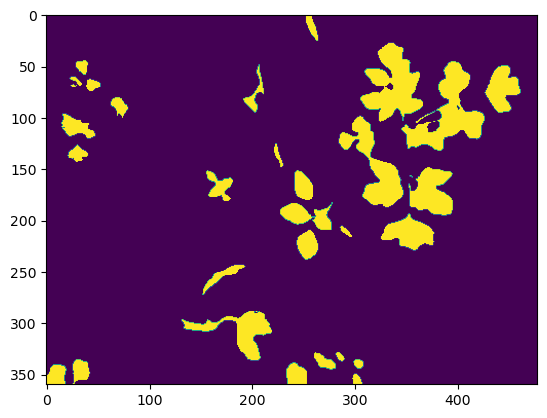

In [156]:
# Read the image
image = cv2.imread('img/img1.png')

# Convert the image from BGR to HSV color space
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the lower and upper bounds for the green color in HSV
lower_green = np.array([30,40,30])
upper_green = np.array([100,255,255])

# Create a mask to isolate the green areas
mask = cv2.inRange(rgb_image, lower_green, upper_green)

# Apply the mask to the original image
green_areas = cv2.bitwise_and(image, image, mask=mask)

arr = green_areas
for i in range(arr.shape[0]):
    for j in range(arr.shape[1]):
        for k in range(arr.shape[2]):
            if arr[i, j, k] != 0:
                arr[i, j, k] = 255

denoised_image = cv2.fastNlMeansDenoisingColored(arr, None, h=100, templateWindowSize=7, searchWindowSize=21)
denoised_image = np.mean(denoised_image, axis=2)
denoised_image[denoised_image > 150] = 255
denoised_image[denoised_image < 150] = 0
plt.figure(); plt.imshow(denoised_image); plt.show()

[[253   0]
 [254   0]
 [255   0]
 ...
 [305 359]
 [306 359]
 [307 359]]


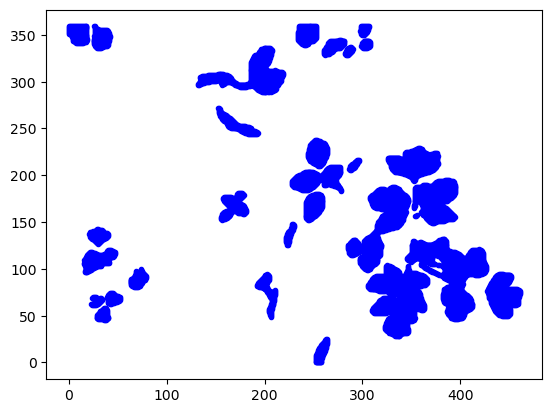

In [157]:
white_points = np.array(np.mat('0 0; 0 0'))
index = 0
x = 0
y = 0
for row in denoised_image:
    for element in row:
        if(element == 255):
            white_points = np.vstack([white_points, [x, y]])
        x = x + 1
    y = y + 1
    x = 0
white_points = np.delete(white_points, (0, 1), axis=0)
print(white_points)

plt.figure(); plt.plot(white_points[:, 0], white_points[:, 1], "b."); plt.show()

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28]


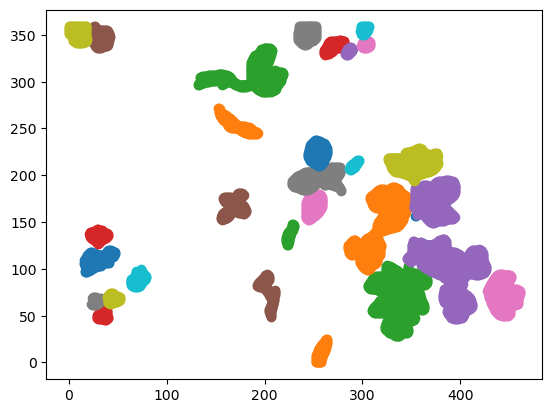

In [158]:
from numpy import unique
from numpy import where
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN

# define the model
dbscan_model = DBSCAN(eps=5, min_samples=10)

# train the model
dbscan_model.fit(white_points)

# assign each data point to a cluster
dbscan_result = dbscan_model.fit_predict(white_points)

# get all of the unique clusters
dbscan_clusters = unique(dbscan_result)
print(dbscan_clusters)

# plot the DBSCAN clusters
for dbscan_cluster in dbscan_clusters:
    # get data points that fall in this cluster
    index = where(dbscan_result == dbscan_cluster)
    # make the plot
    pyplot.scatter(white_points[index, 0], white_points[index, 1])

# show the DBSCAN plot
pyplot.show()

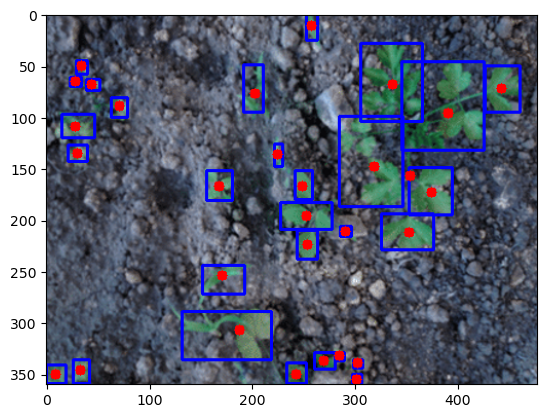

In [163]:
# Find the bounding box for each cluster
bounding_boxes = find_bounding_boxes(white_points, dbscan_result)

# Find the center of each cluster
cluster_centers = find_cluster_centers(white_points, dbscan_result)

# Draw boxes and circles
img_processed = np.copy(image)
plot_boxes(img_processed, bounding_boxes)
plot_centers(img_processed, cluster_centers)

plt.imshow(img_processed)
plt.show()

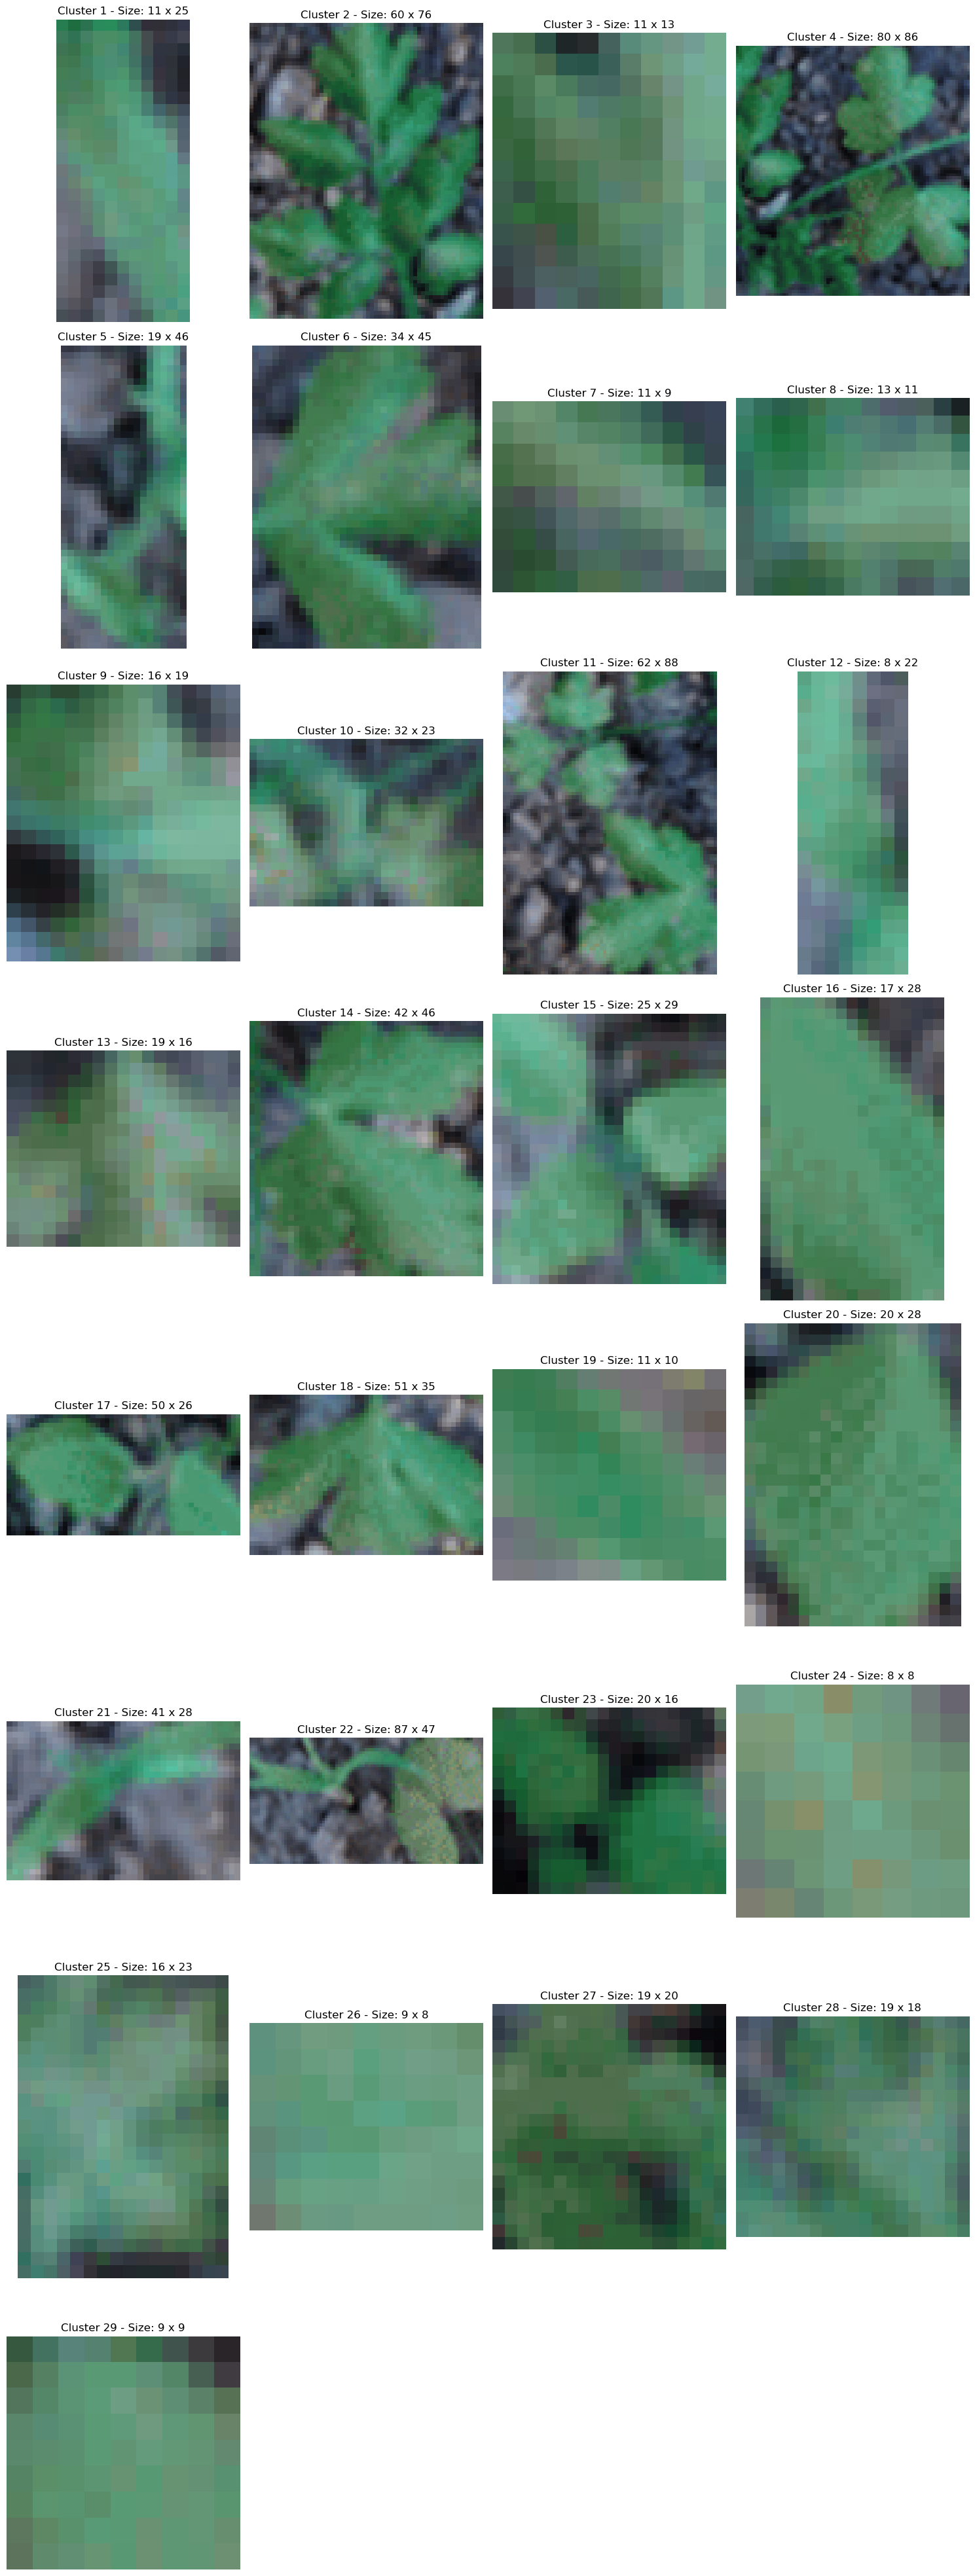

In [202]:
# Plot each cluster of weed on a separate subplot with the size of the subplot corresponding to each box size
num_clusters = len(bounding_boxes)
num_cols = 4
num_rows = -(-num_clusters // num_cols)

plt.figure(figsize=(15, 5*num_rows))

for i, box in enumerate(bounding_boxes, start=0):
    (min_x, min_y), (max_x, max_y) = box
    box_width = max_x - min_x
    box_height = max_y - min_y
    
    if box_width <= 0 or box_height <= 0:
        continue
    
    plt.subplot(num_rows, num_cols, i)
    plt.imshow(image[min_y:max_y, min_x:max_x])
    plt.axis('off')
    plt.title(f'Cluster {i} - Size: {box_width} x {box_height}')

plt.tight_layout()
plt.show()